<a href="https://colab.research.google.com/github/aliei11/aliei11/blob/main/SCDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
local_path='/content/drive/MyDrive/SC_DataAnalysis'   # PASTE YOUR LOCAL PATH IN PLACE OF /content
%cd {local_path}

/content/drive/MyDrive/SC_DataAnalysis


In [4]:
ls

BreastSample/  cache/  figures/  filtered_gene_bc_matrices/  pbmc3k.h5ad


In [ ]:
!pip install scanpy

In [6]:
import numpy as np
import pandas as pd
import scanpy as sc

In [7]:
#sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
#sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

In [8]:
results_file = 'pbmc3k.h5ad'  # the file that will store the analysis results

Read in the count matrix into an AnnData object, which holds many slots for annotations and different representations of the data. It also comes with its own HDF5-based file format: .h5ad.

#**Loading Data**

In this study, I used the **human PBMC** dataset from 10x genomics.
First, we read the count matrix into an AnnData object, which holds many slots for annotations and different representations of the data.
It consists of 2700 observations (cells) and 32738 variables (number of genes). This translates into barcodes x number of transcripts.
Please note that genes and cells are placed in columns and rows, respectively. (In contrast with Seurat Object.)

In [10]:
adata = sc.read_10x_mtx(
    'filtered_gene_bc_matrices/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)                              # write a cache file for faster subsequent reading

adata

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

#**Preprocessing**

Befre preprocessing step, here, we show those genes that yield the highest fraction of counts in each single cell, across all cells.

normalizing counts per cell
    finished (0:00:00)


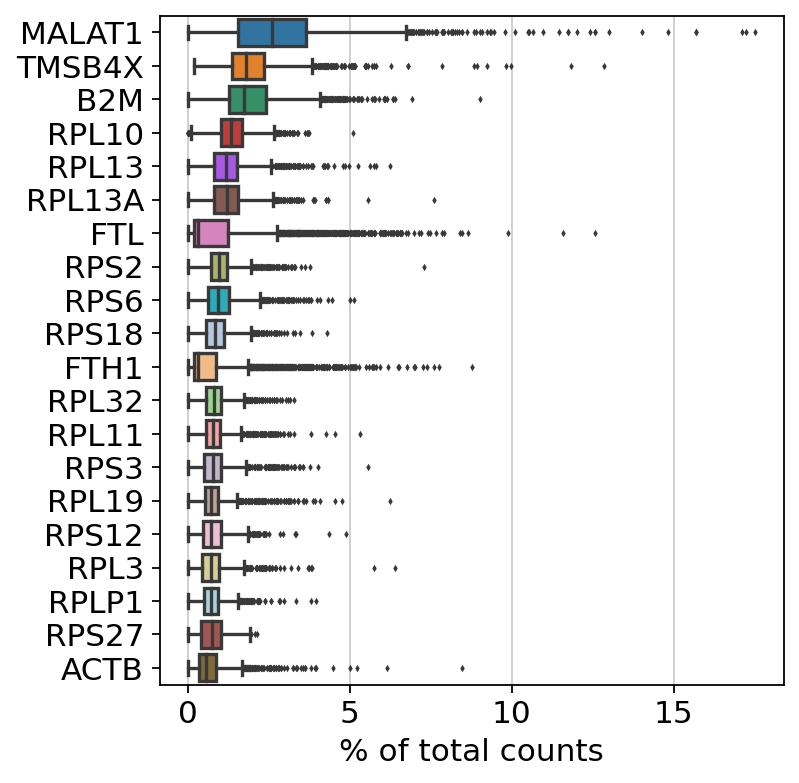

In [11]:
# Show those genes that yield the highest fraction of counts in each single cell, across all cells.
sc.pl.highest_expr_genes(adata, n_top=20 )

Quality control was performed to filter out low-quality cells and genes that could introduce noise into the analysis. This step ensures that the subsequent analysis focuses on high-quality cells and genes. Cells with low total counts and genes with low counts are commonly removed as they may indicate technical issues or low-quality data. Additionally, cells with high mitochondrial gene expression are often excluded as increased mitochondrial gene expression can be a sign of cell stress or low quality.

In [12]:
# Basic filtering:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

Previous codes, added the column describing in which each gene is expressed in the number of cells.

In [13]:
adata.var

,gene_ids,n_cells
AL627309.1,ENSG00000237683,9
AP006222.2,ENSG00000228463,3
RP11-206L10.2,ENSG00000228327,5
RP11-206L10.9,ENSG00000237491,3
LINC00115,ENSG00000225880,18
...,...,...
AC145212.1,ENSG00000215750,16
AL592183.1,ENSG00000220023,323
AL354822.1,ENSG00000215615,8
PNRC2-1,ENSG00000215700,110


We then define mitochondrial genes. and calculate the respective QC metrics.
All the information storer in .var an .obs .

In [16]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

adata.var

,gene_ids,n_cells,mt,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts
AL627309.1,ENSG00000237683,9,False,9,0.003333,99.666667,9.0
AP006222.2,ENSG00000228463,3,False,3,0.001111,99.888889,3.0
RP11-206L10.2,ENSG00000228327,5,False,5,0.001852,99.814815,5.0
RP11-206L10.9,ENSG00000237491,3,False,3,0.001111,99.888889,3.0
LINC00115,ENSG00000225880,18,False,18,0.006667,99.333333,18.0
...,...,...,...,...,...,...,...
AC145212.1,ENSG00000215750,16,False,16,0.006667,99.407407,18.0
AL592183.1,ENSG00000220023,323,False,323,0.134815,88.037037,364.0
AL354822.1,ENSG00000215615,8,False,8,0.002963,99.703704,8.0
PNRC2-1,ENSG00000215700,110,False,110,0.042963,95.925926,116.0


In [17]:
adata.obs

,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt
AAACATACAACCAC-1,781,779,2419.0,73.0,3.017776
AAACATTGAGCTAC-1,1352,1352,4903.0,186.0,3.793596
AAACATTGATCAGC-1,1131,1129,3147.0,28.0,0.889736
AAACCGTGCTTCCG-1,960,960,2639.0,46.0,1.743085
AAACCGTGTATGCG-1,522,521,980.0,12.0,1.224490
...,...,...,...,...,...
TTTCGAACTCTCAT-1,1155,1153,3459.0,73.0,2.110436
TTTCTACTGAGGCA-1,1227,1224,3443.0,32.0,0.929422
TTTCTACTTCCTCG-1,622,622,1684.0,37.0,2.197150
TTTGCATGAGAGGC-1,454,452,1022.0,21.0,2.054795


In the example below, we visualize QC metrics, and use these to filter cells.

We filter cells that have unique feature counts over 2,500 or less than 200
We filter cells that have >5% mitochondrial counts

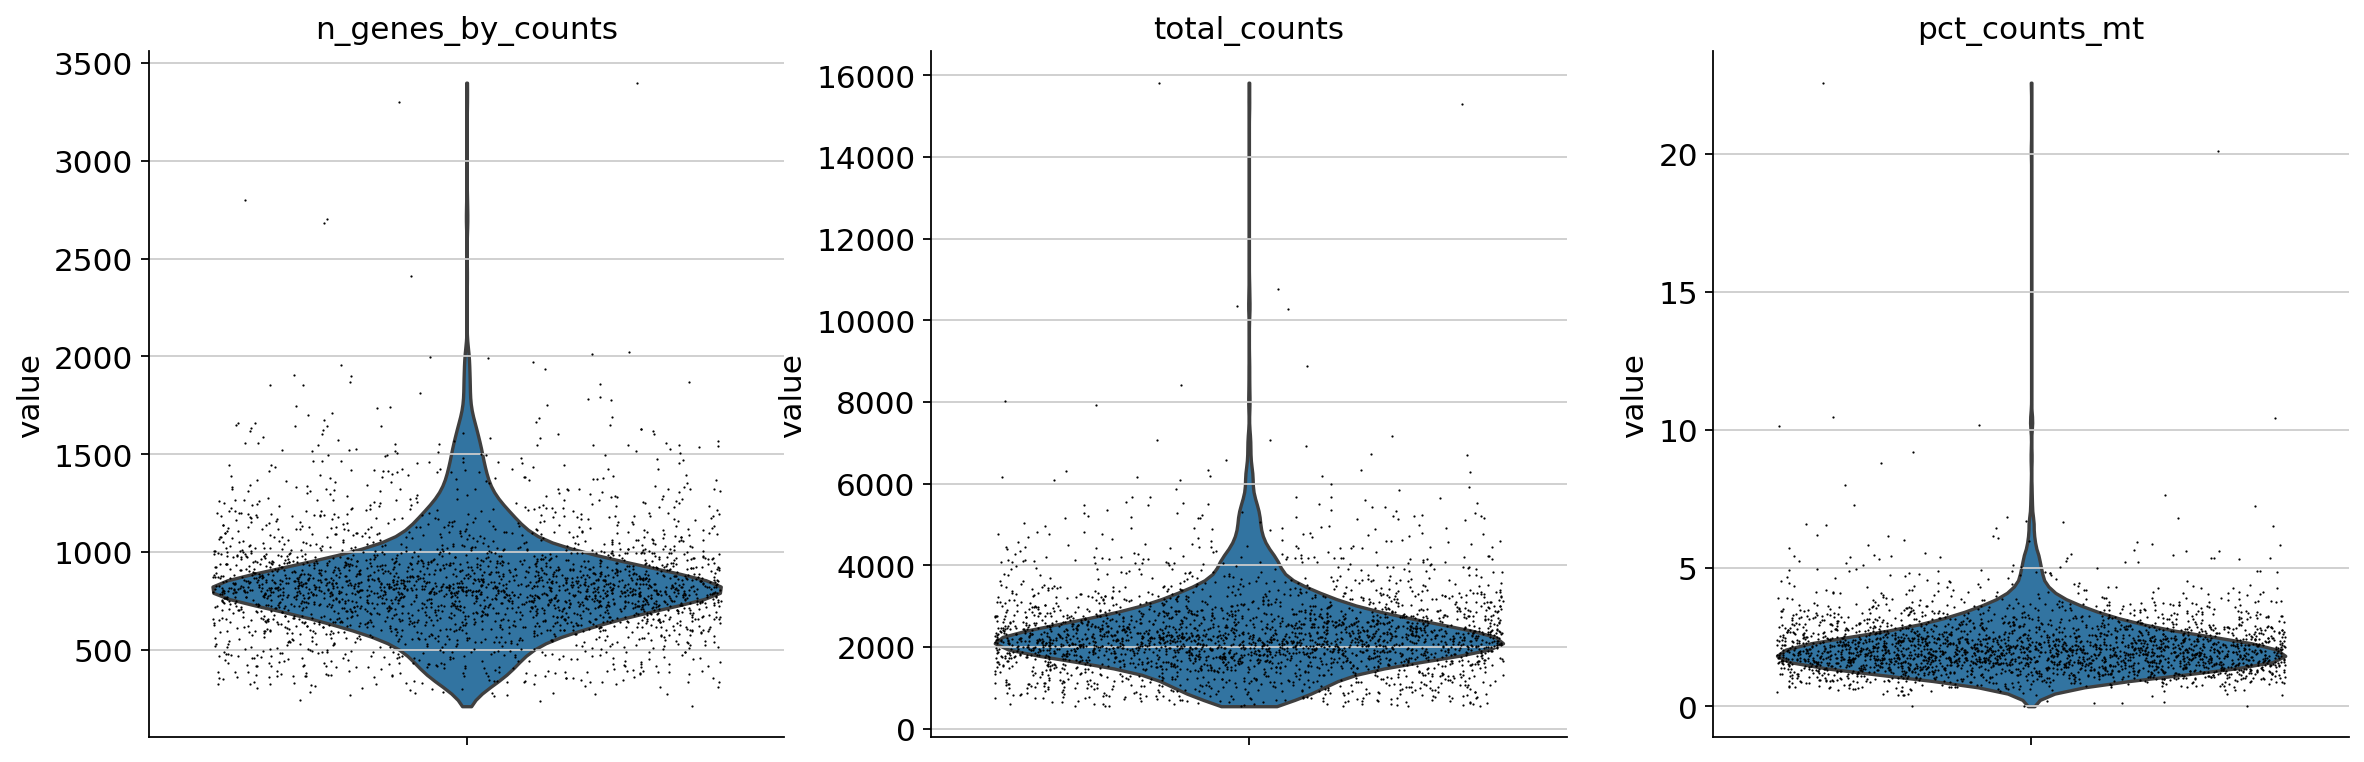

In [18]:
# A violin plot of some of the computed quality measures:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], multi_panel=True, jitter=0.4
             )

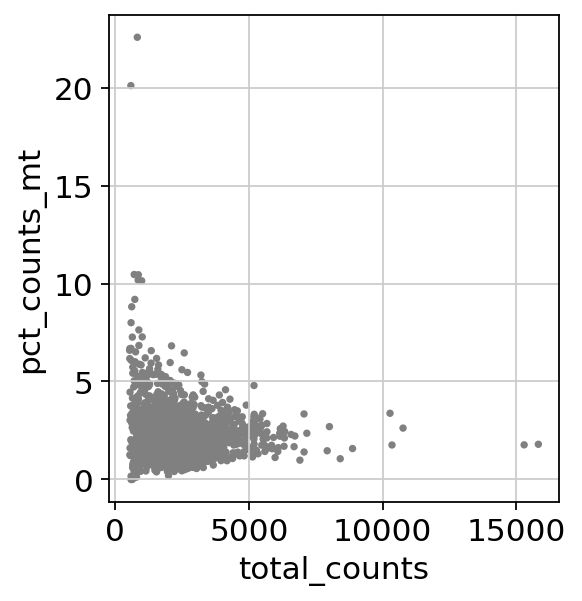

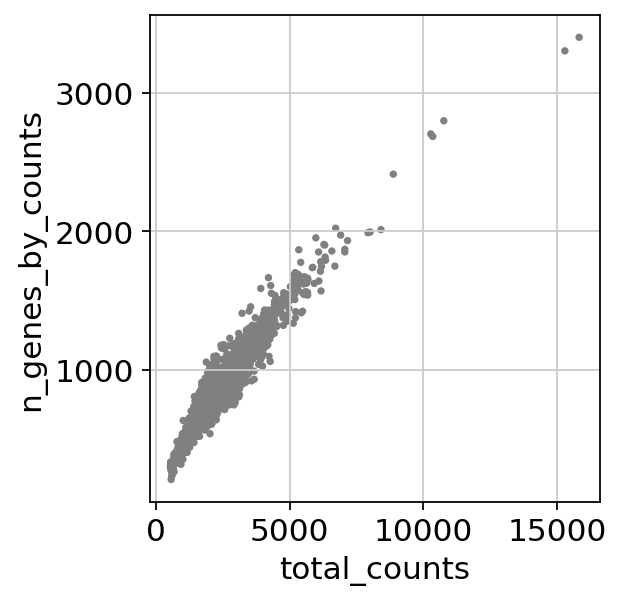

In [19]:
# Remove cells that have too many mitochondrial genes expressed or too many total counts:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [20]:
# filter out genes counted more than 2500 with mt count higher than 5 percents:
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]


In [24]:
adata

View of AnnData object with n_obs × n_vars = 2638 × 13714
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

Gene expression values were normalized to account for differences in library sizes and total RNA content across cells. This step ensures that the expression values are comparable across cells. Various normalization methods can be used, such as total-count normalization or library-size scaling.

Normalization is important for downstream analyses, such as clustering or differential expression analysis.

In [25]:
# Total-count normalize (library-size correct) the data matrix 𝐗 to 10,000 reads per cell, so that counts become comparable among cells.
sc.pp.normalize_total(adata, target_sum=1e4)

/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


After normalization, a **logarithmic transformation** is often applied to the gene expression values. This transformation helps to stabilize the variance across the expression values and makes the data more amenable to subsequent analyses. Logarithmic transformation is commonly performed using the natural logarithm (log1p function in Scanpy) to avoid issues with zero counts.

In [26]:
# Logarithmize the data:
sc.pp.log1p(adata)

In [27]:
# Identify highly-variable genes.
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

Here, the normalized and highly variable genes are stored in .uns as unstructured part of AnnData.

In [29]:
adata

AnnData object with n_obs × n_vars = 2638 × 13714
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

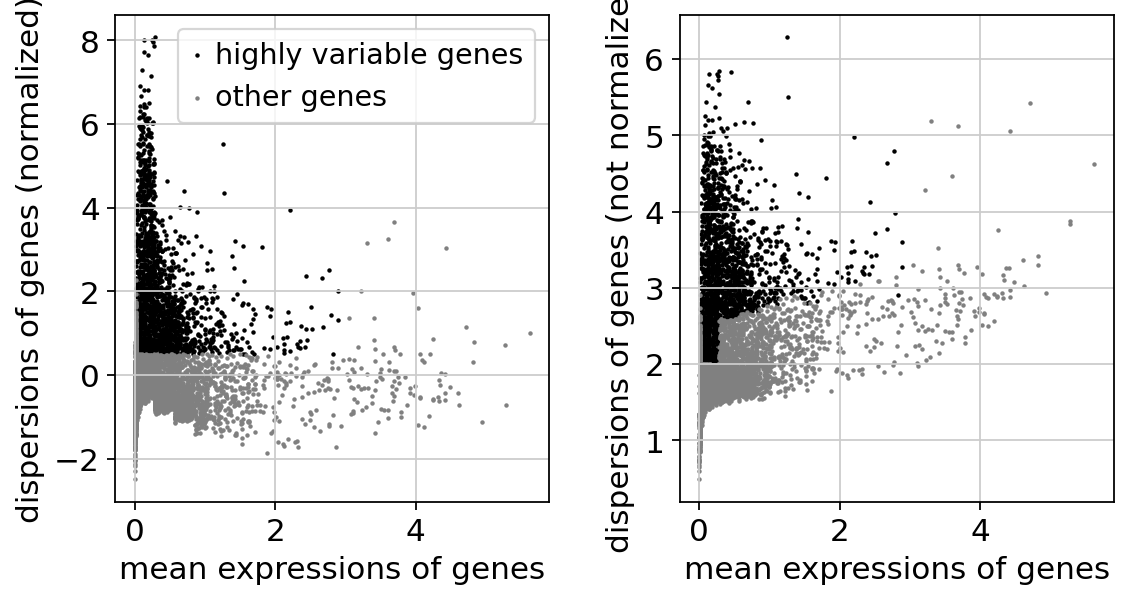

In [30]:
sc.pl.highly_variable_genes(adata)

Here, we stored the attribute of the AnnData object to the normalized and logarithmized raw gene expression for later use in differential testing and visualizations of gene expression. (These are stored in .raw)

In [31]:
# This simply freezes the state of the AnnData object.
adata.raw = adata

# I can get back an AnnData of the object in .raw by calling .raw.to_adata()

In [32]:
# Start doing filtering:
adata = adata[:, adata.var.highly_variable]

In [33]:
# Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed. Scale the data to unit variance
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

The gene expression values are typically scaled to bring them to a similar range. This step is important for dimensionality reduction methods, such as principal component analysis (PCA), as it prevents genes with high expression levels from dominating the analysis.

In [34]:
# Scale each gene to unit variance. Clip values exceeding standard deviation 10.
sc.pp.scale(adata, max_value=10)

#**Principle Component Analysis**

**PCA** is applied to the preprocessed and scaled data to capture the major sources of variation in the dataset. It reduces the high-dimensional gene expression data into a lower-dimensional representation of principal components (PCs). These PCs represent linear combinations of genes that explain the most significant variation in the dataset. PCA is useful for visualizing and clustering cells, as well as for reducing the dimensionality of the data for downstream analyses.

In [35]:
# Reduce the dimensionality of the data
# which reveals the main axes of variation and denoises the data.
sc.tl.pca(adata, svd_solver='arpack')

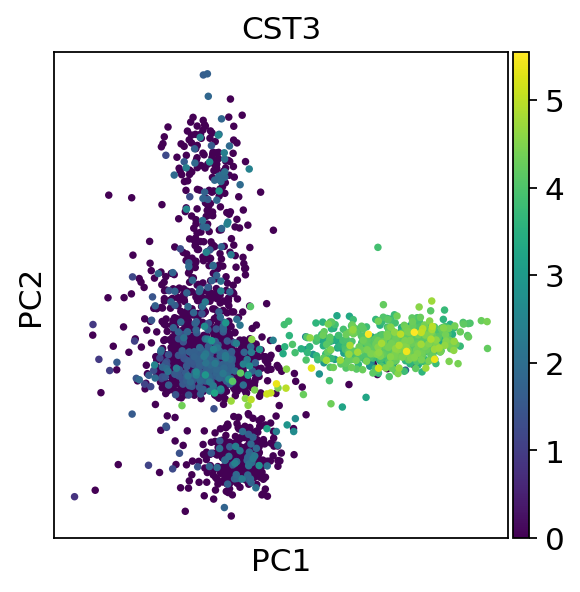

In [36]:
sc.pl.pca(adata, color='CST3')

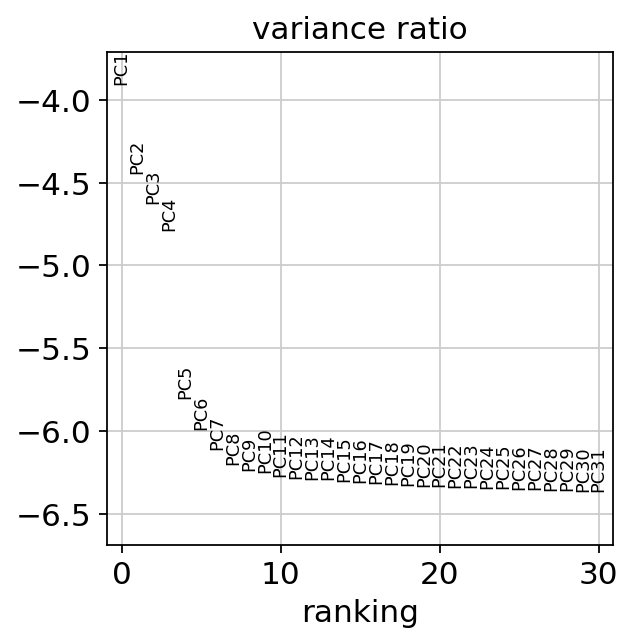

In [37]:
sc.pl.pca_variance_ratio(adata, log = True)

In [38]:
# Saving result
adata.write(results_file)

In [39]:
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

#**Computing the neighborhood graph**

In clustering analysis, a graph-based approach is commonly used to identify groups of cells with similar expression profiles. The first step in this process is constructing a nearest neighbor graph, which represents the pairwise similarities or distances between cells.

In [40]:
# compute the neighborhood graph of cells using the PCA representation of the data matrix
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

#**Embedding the neighborhood graph**

The Leiden algorithm uses an optimization approach to partition cells into clusters based on modularity. It iteratively moves cells between clusters to maximize the modularity score, resulting in more refined and well-separated clusters.

UMAP constructs a high-dimensional graph representation of the data and optimizes the embedding in a low-dimensional space to minimize the discrepancy between the graph distances and the distances in the embedding.

In [ ]:
!pip3 install leidenalg

In [42]:
# embedding the graph in two dimensions using UMAP
# It is potentially more faithful to the global connectivity of the manifold than tSNE, i.e., it better preserves trajectories.
# In some ocassions, we might still observe disconnected clusters and similar connectivity violations. They can usually be remedied by running:

sc.tl.leiden(adata)
sc.tl.paga(adata)
sc.pl.paga(adata, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
sc.tl.umap(adata, init_pos='paga')

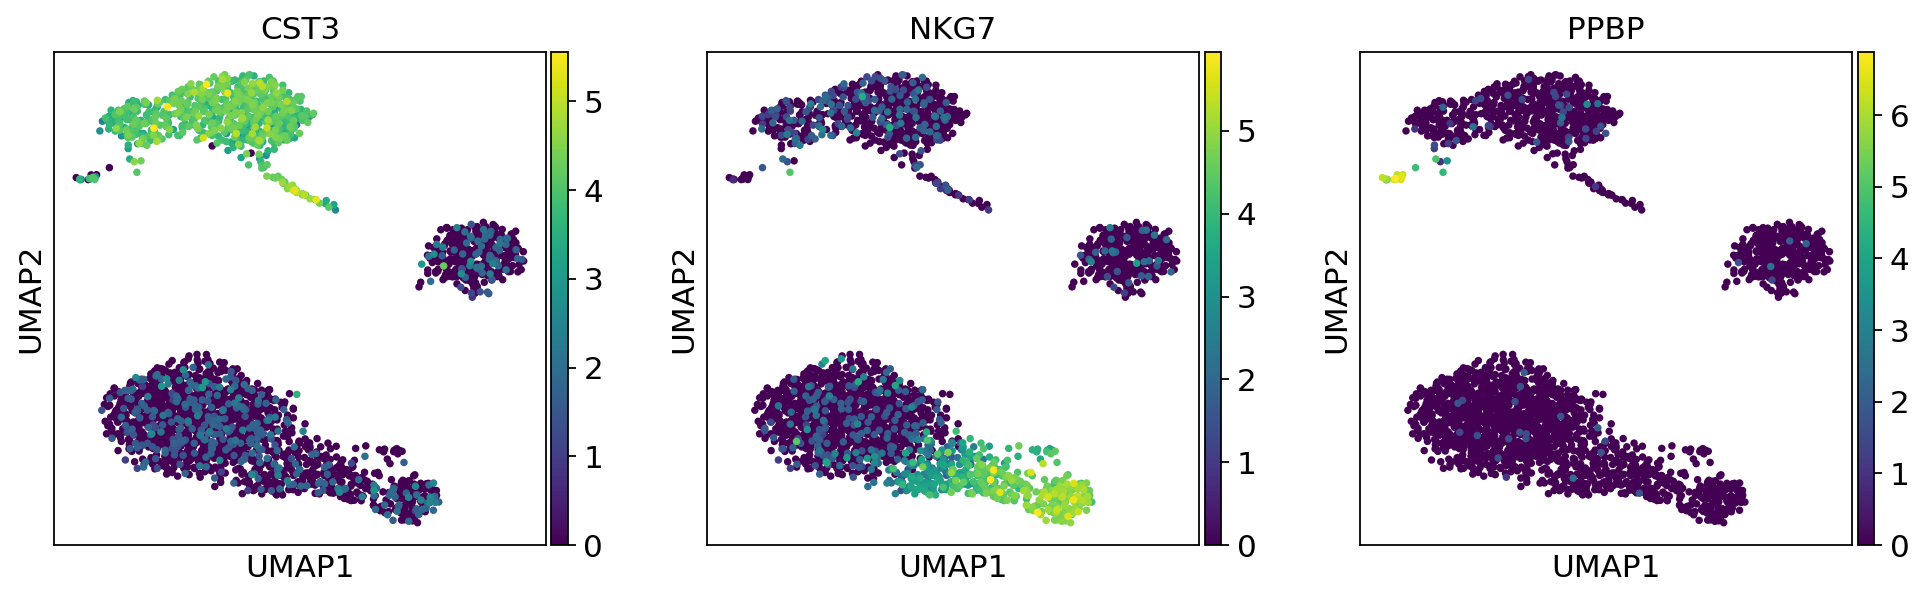

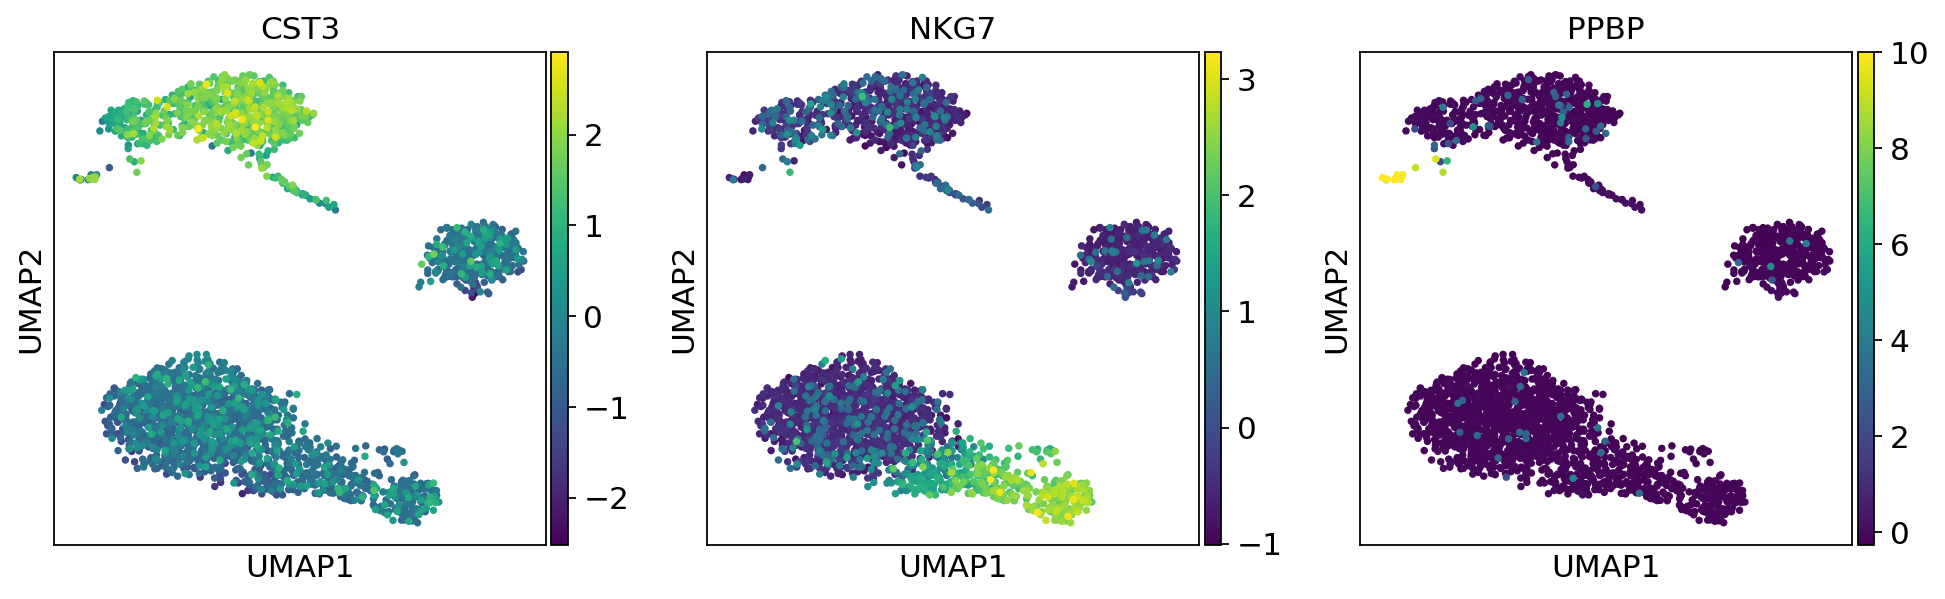

In [43]:
sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP'])
sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP'], use_raw=False)


#**Clustering the neighborhood graph**

Leiden clustering directly clusters the neighborhood graph of cells, which we already computed in the previous section.

After applying the Leiden algorithm, the resulting cell clusters can be visualized using t-SNE or UMAP, as described before. The visualization plots help visualize the separation and distribution of cells in the low-dimensional space based on their expression profiles within the identified Leiden clusters.

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


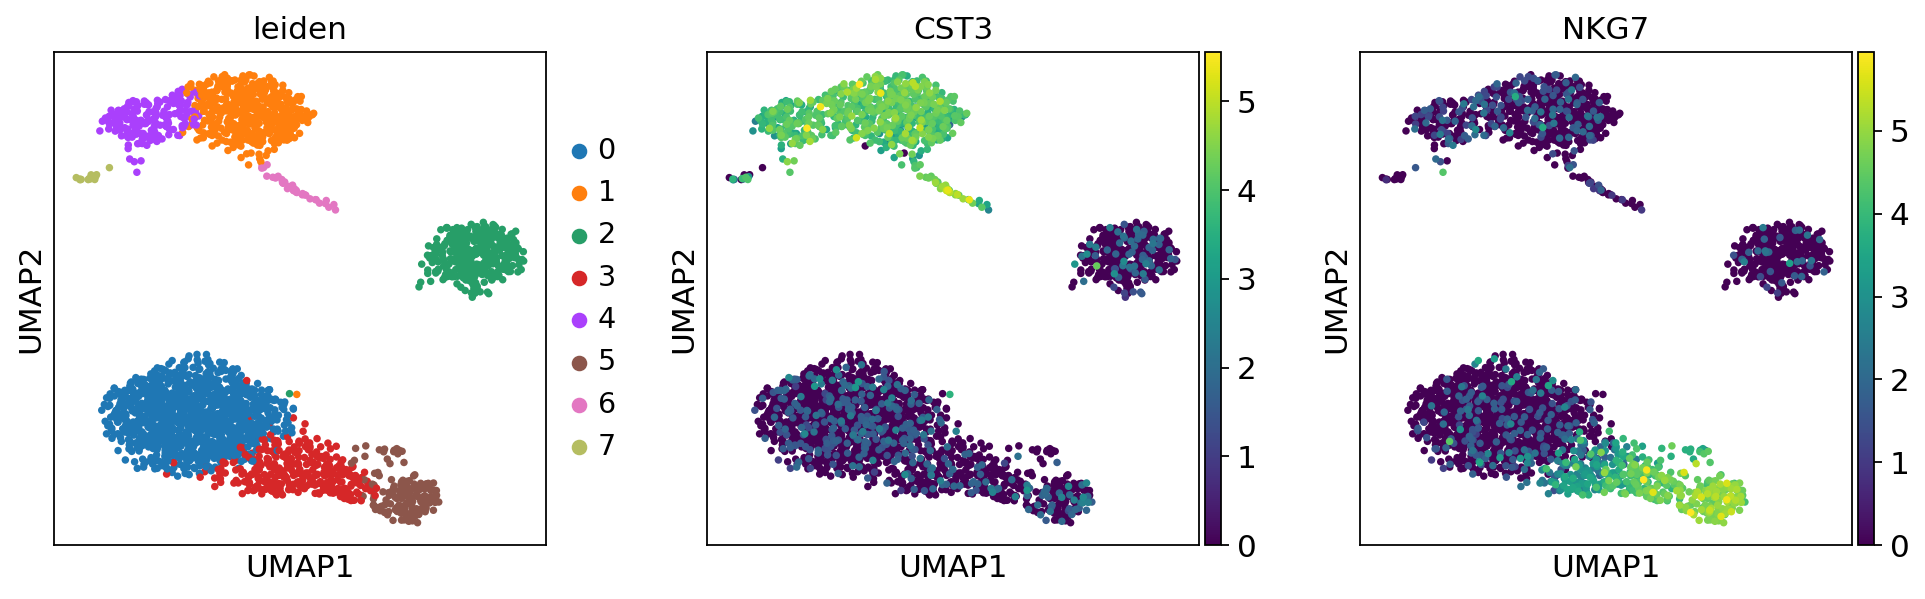

In [44]:
# Plotting the clusters
sc.pl.umap(adata, color=['leiden', 'CST3', 'NKG7'])


In [45]:
adata.write(results_file)

#**Cluster Annotation**

Marker gene analysis is a common approach to assign biological labels or annotations to the identified cell clusters. This analysis aims to identify genes that are highly expressed in specific clusters compared to others. These genes act as markers that are indicative of particular cell types, states, or biological processes.

 To identify marker genes, differential expression analysis is performed between each pair of clusters. This analysis compares the expression levels of genes in one cluster against the expression levels in other clusters, using *statistical tests* such as the *t-test*, *Wilcoxon rank-sum test*, or *likelihood ratio test*. Genes with significantly higher expression in a particular cluster are considered potential marker genes for that cluster.

 Statistical tests, such as the **t-test** or **Wilcoxon rank-sum test**, compare the expression levels of genes between different clusters to identify genes that show significant differences in expression. These tests are commonly used for differential expression analysis in bulk RNA-seq data and can be adapted for single-cell RNA-seq data as well. They are particularly suitable when comparing expression levels between two groups or clusters.

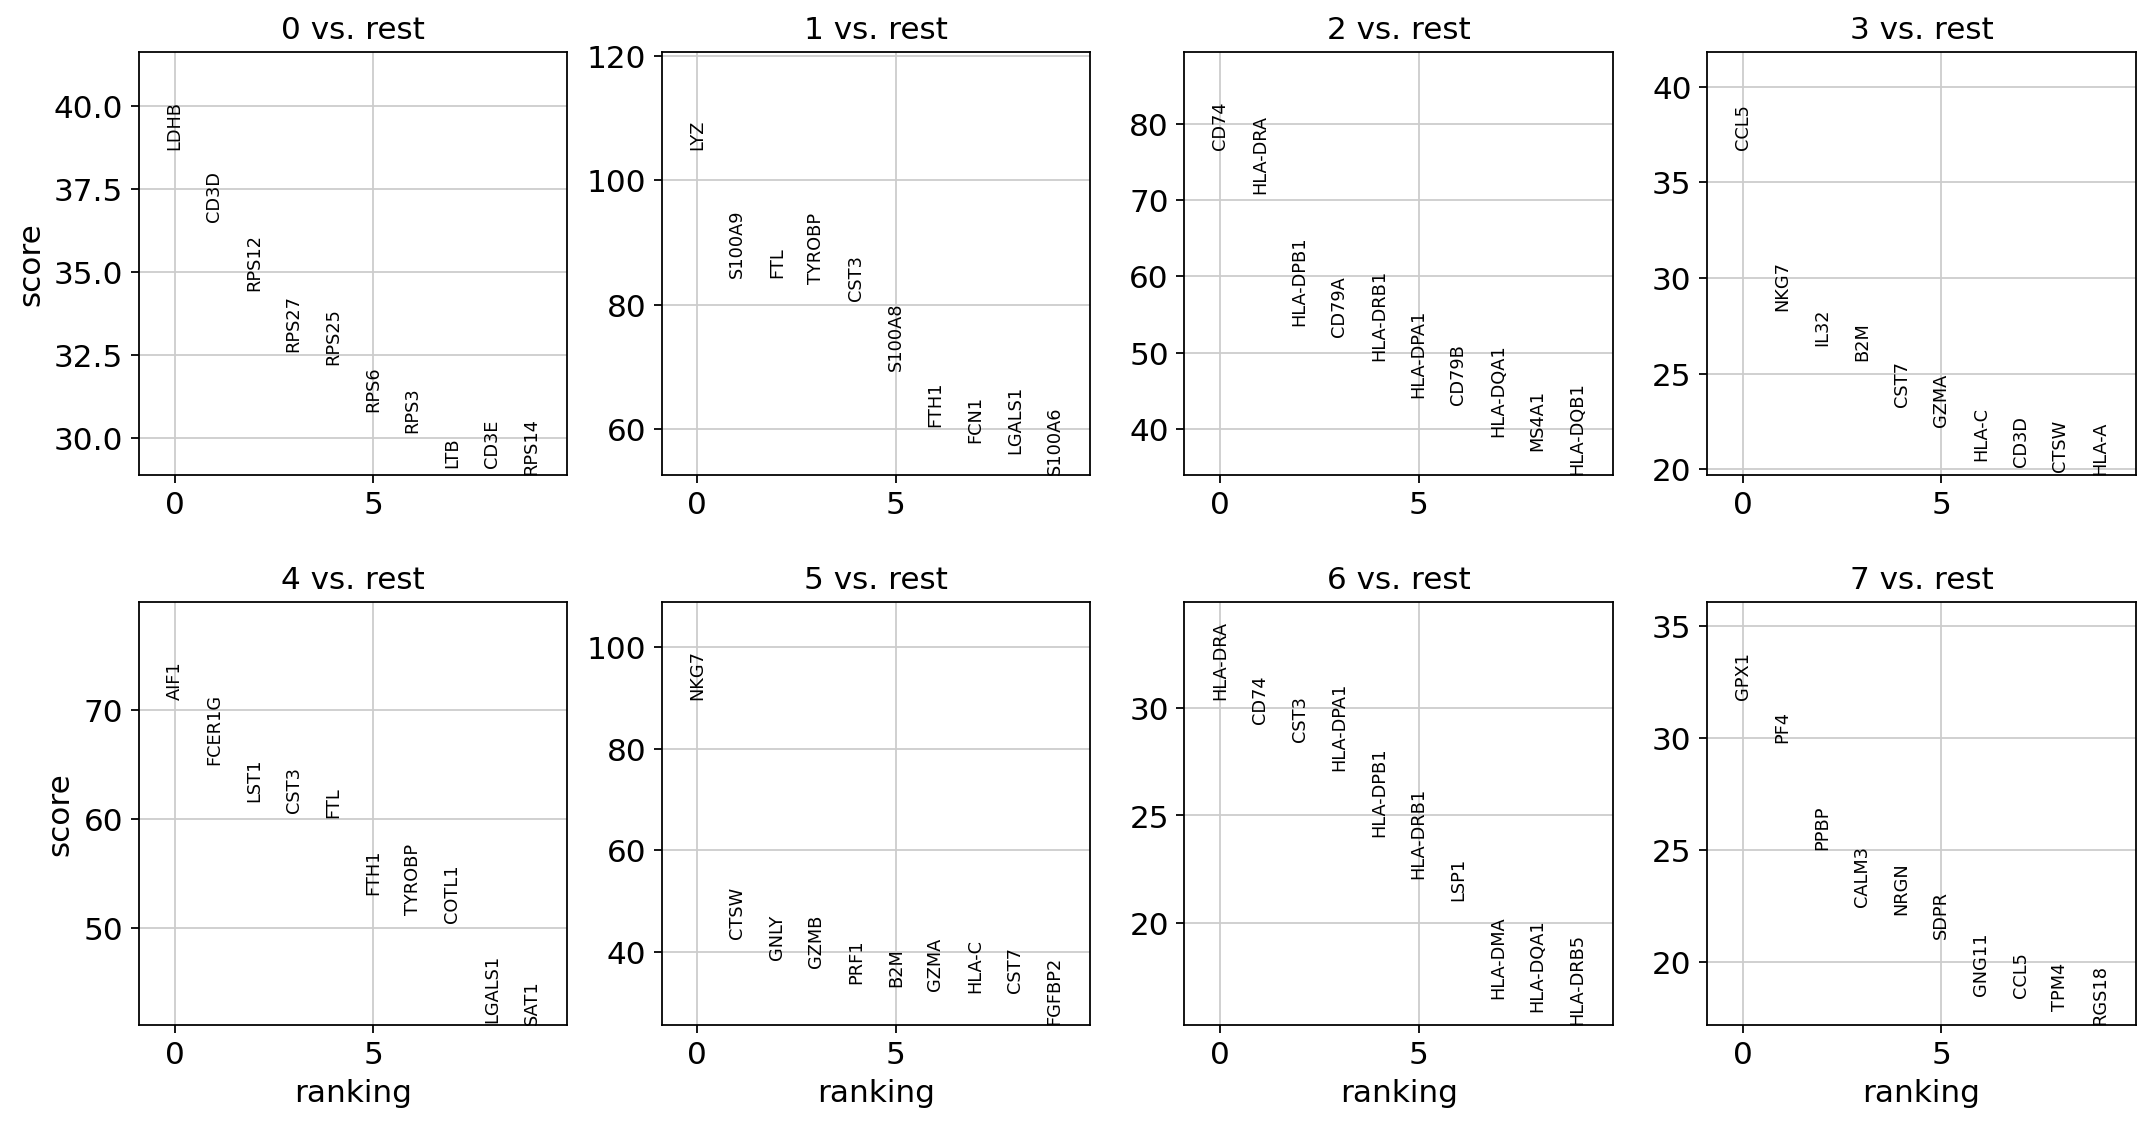

In [46]:
# Compute a ranking for the highly differential genes in each cluster
# By default, the .raw attribute of AnnData is used in case it has been initialized before.
# The simplest and fastest method to do so is the t-test.

sc.tl.rank_genes_groups(adata, groupby='leiden', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=10, sharey=False)

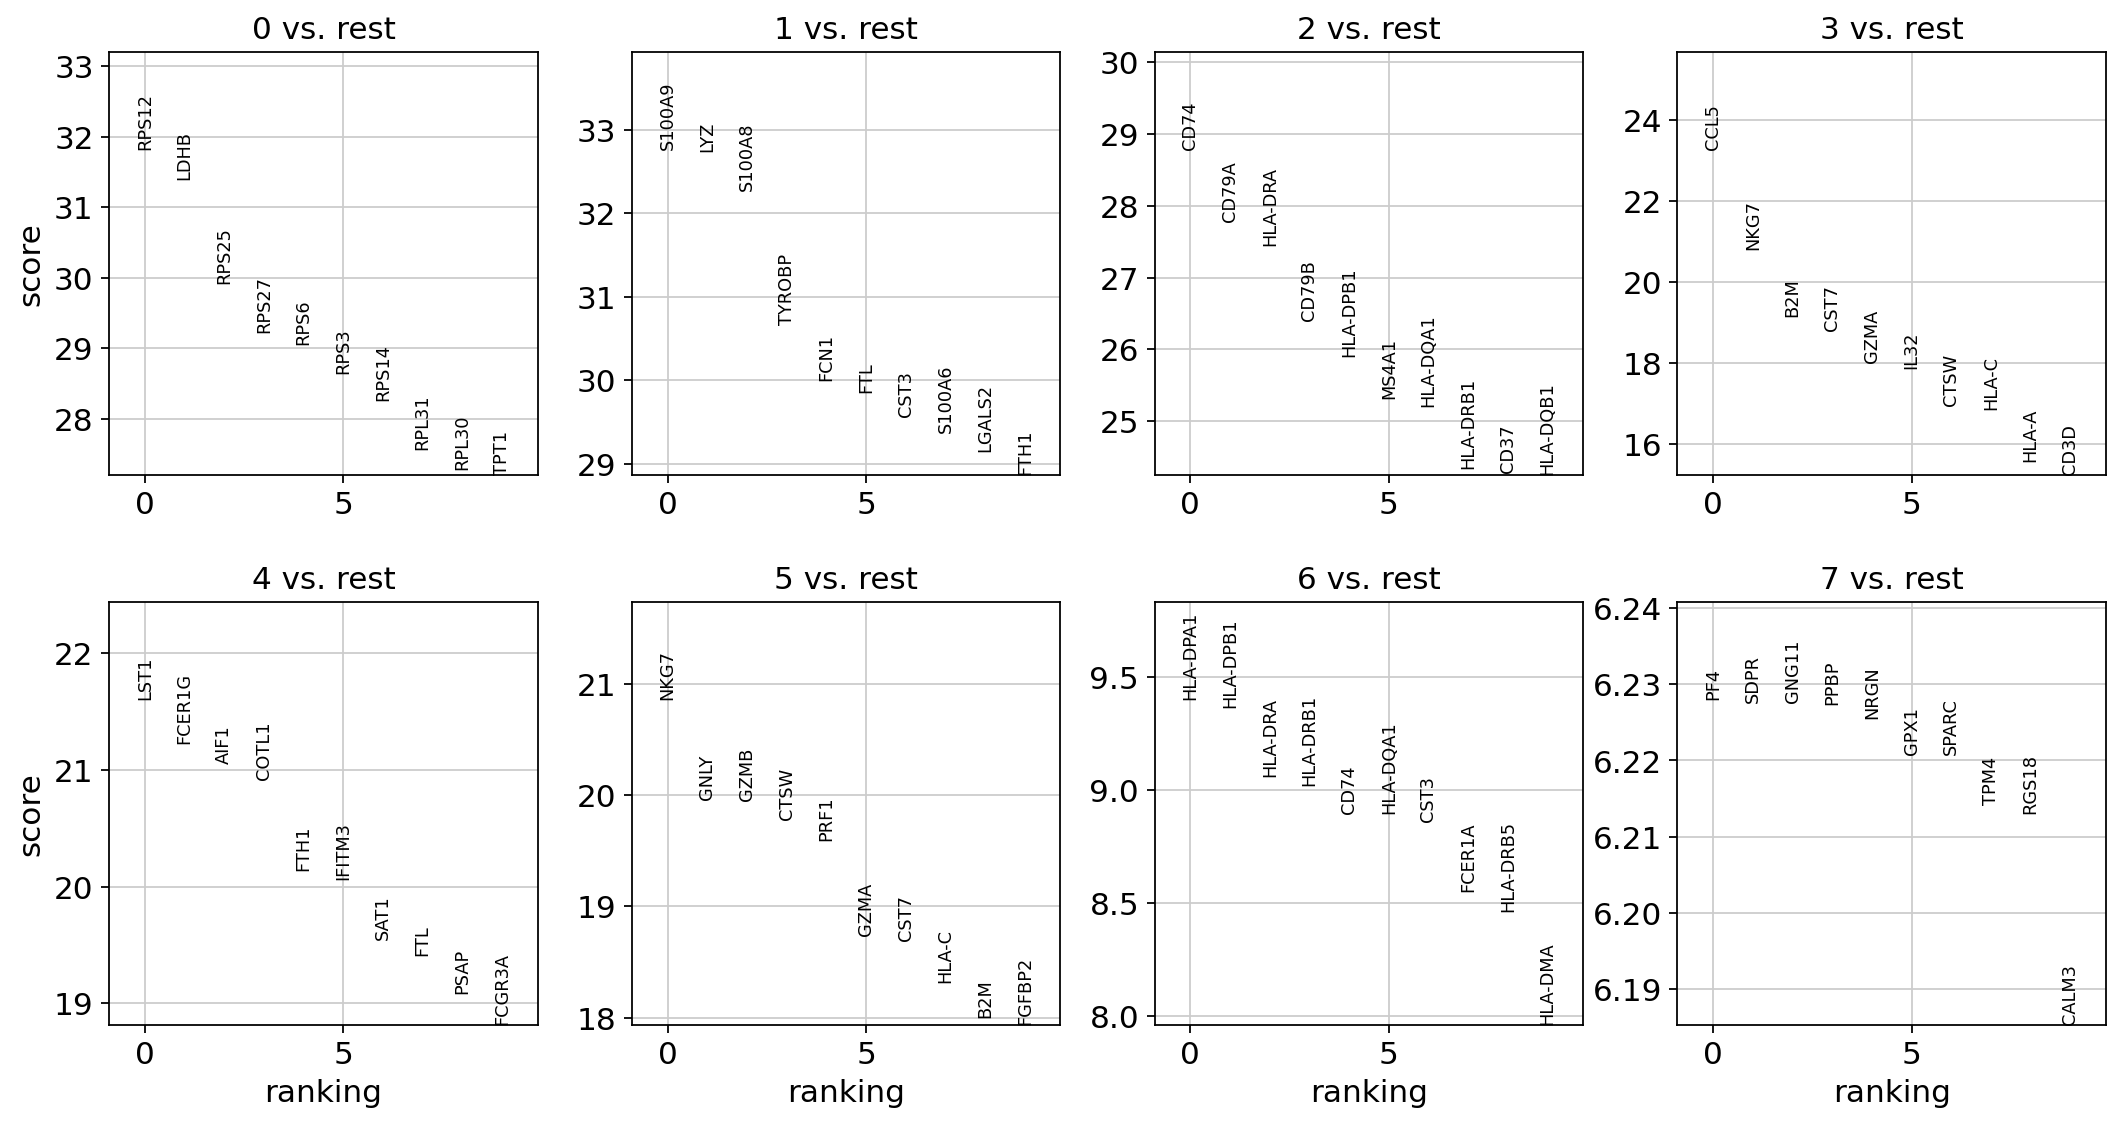

In [47]:
# The Wilcoxon rank-sum test method:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=10, sharey=False)

In [48]:
adata.write(results_file)

**Logistic regression** is a statistical modeling approach that is well-suited for binary outcomes, such as the presence or absence of a specific cell type or state within a cluster. It models the relationship between gene expression levels and the likelihood of a cell belonging to a particular cluster.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


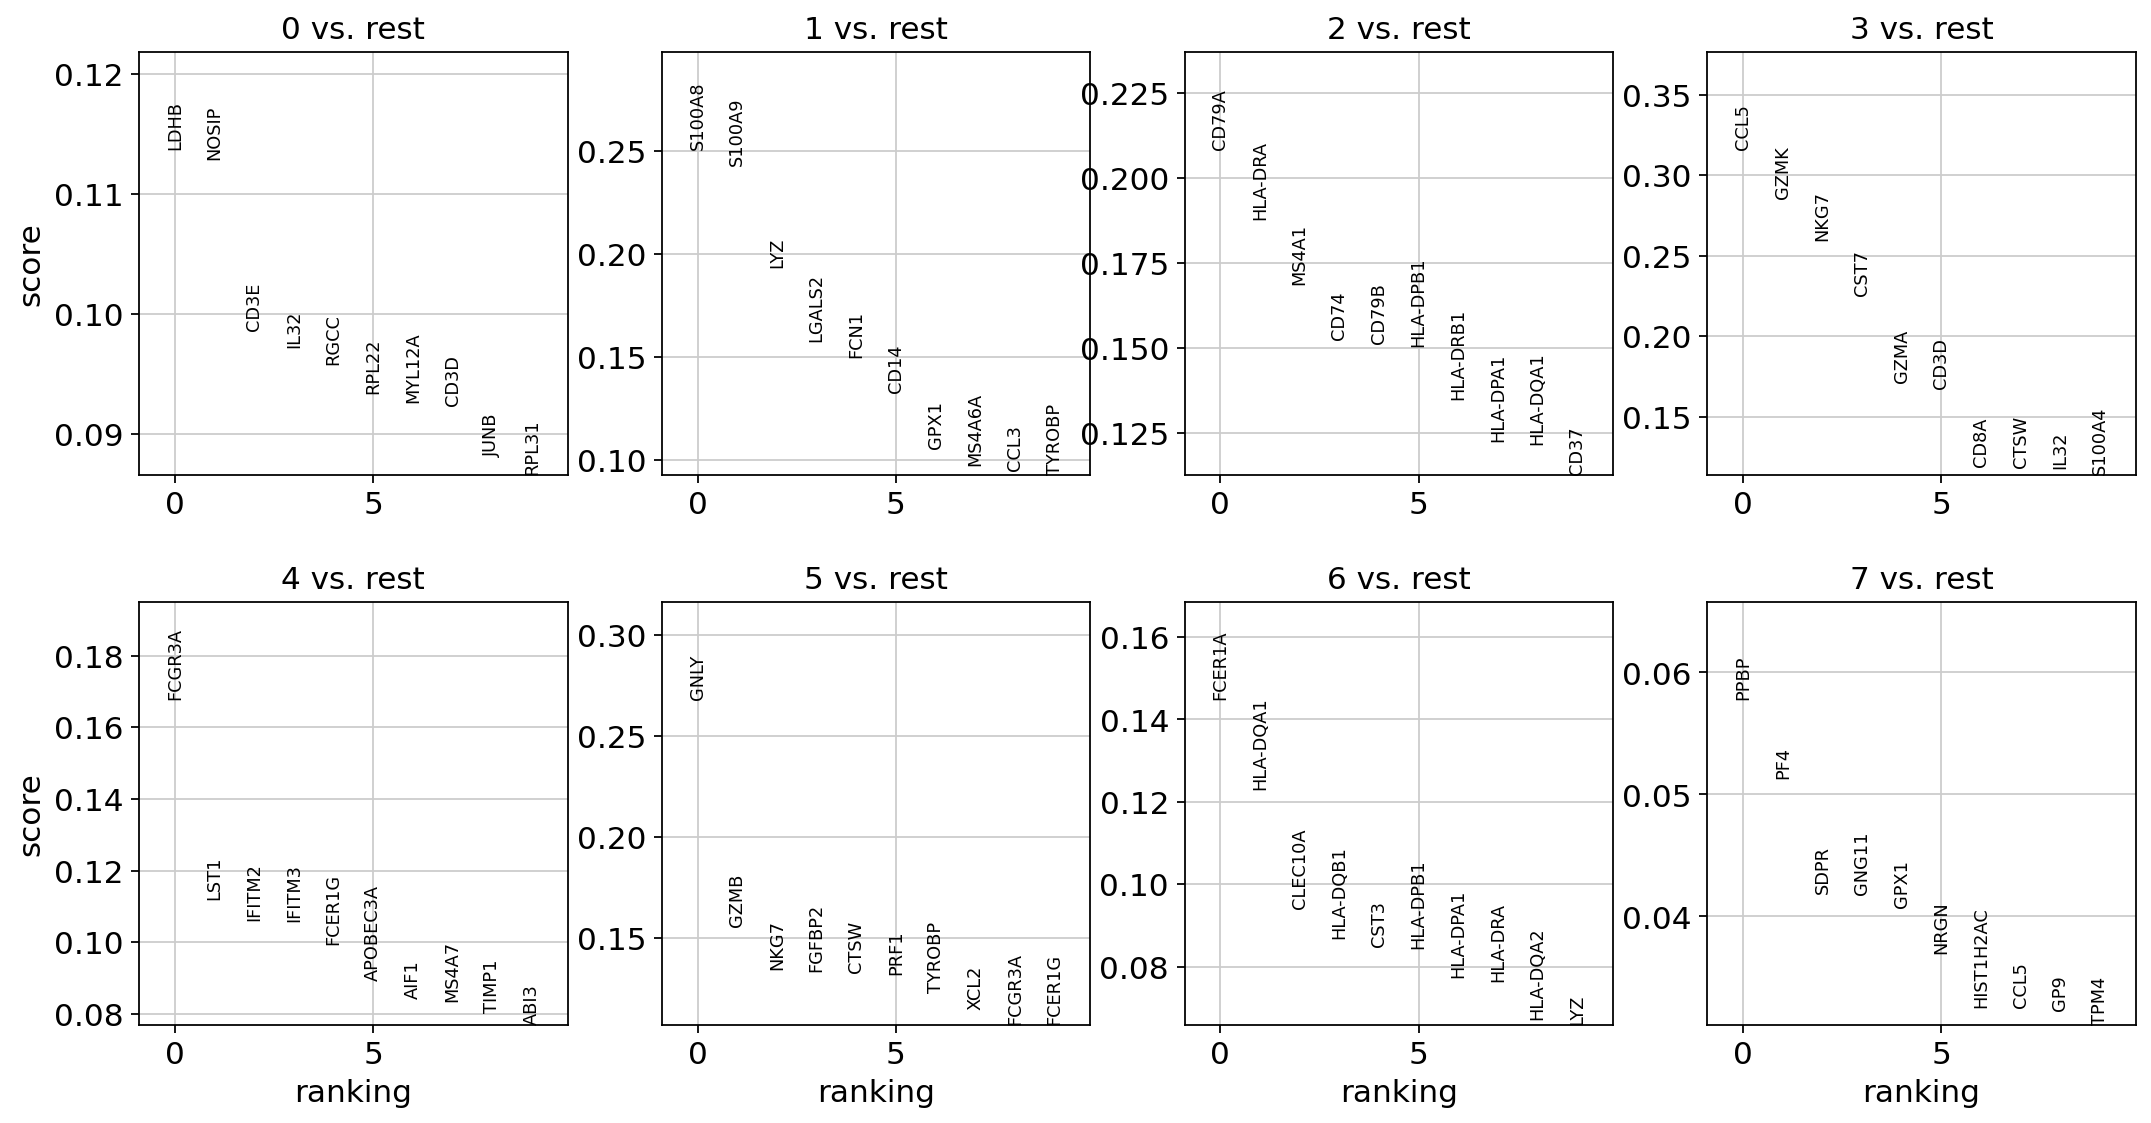

In [49]:
# Rank genes using logistic regression:
# The essential difference is that here, we use a multi-variate appraoch whereas conventional differential tests are uni-variate.
sc.tl.rank_genes_groups(adata, 'leiden', method='logreg')
sc.pl.rank_genes_groups(adata, n_genes=10, sharey=False)

In [50]:
marker_genes = ['IL7R', 'CD79A', 'MS4A1', 'CD8A', 'CD8B', 'LYZ', 'CD14',
                'LGALS3', 'S100A8', 'GNLY', 'NKG7', 'KLRB1',
                'FCGR3A', 'MS4A7', 'FCER1A', 'CST3', 'PPBP']

In [51]:
# Reload the object that has been save with the Wilcoxon Rank-Sum test result

adata = sc.read(results_file)

Marker genes are identified and ranked based on statistical significance, fold change, or other relevant metrics. This ranking helps identify the most informative genes that distinguish one cluster from others. Top-ranking marker genes with high expression in a specific cluster provide valuable insights into the molecular characteristics or functional properties of the cells within that cluster.

In [52]:
# Show the 10 top ranked genes per cluster 0, 1, …, 7 in a dataframe.
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(10)

,0,1,2,3,4,5,6,7
0,RPS12,S100A9,CD74,CCL5,LST1,NKG7,HLA-DPA1,PF4
1,LDHB,LYZ,CD79A,NKG7,FCER1G,GNLY,HLA-DPB1,SDPR
2,RPS25,S100A8,HLA-DRA,B2M,AIF1,GZMB,HLA-DRA,GNG11
3,RPS27,TYROBP,CD79B,CST7,COTL1,CTSW,HLA-DRB1,PPBP
4,RPS6,FCN1,HLA-DPB1,GZMA,FTH1,PRF1,CD74,NRGN
5,RPS3,FTL,MS4A1,IL32,IFITM3,GZMA,HLA-DQA1,GPX1
6,RPS14,CST3,HLA-DQA1,CTSW,SAT1,CST7,CST3,SPARC
7,RPL31,S100A6,HLA-DRB1,HLA-C,FTL,HLA-C,FCER1A,TPM4
8,RPL30,LGALS2,CD37,HLA-A,PSAP,B2M,HLA-DRB5,RGS18
9,TPT1,FTH1,HLA-DQB1,CD3D,FCGR3A,FGFBP2,HLA-DMA,CALM3


In [53]:
# Get a table with the scores and groups:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(5)

,0_n,0_p,1_n,1_p,2_n,2_p,3_n,3_p,4_n,4_p,5_n,5_p,6_n,6_p,7_n,7_p
0,RPS12,3.639461e-222,S100A9,1.940467e-235,CD74,3.043536e-182,CCL5,8.082693e-120,LST1,1.620366e-103,NKG7,1.203971e-96,HLA-DPA1,5.422417e-21,PF4,4.722886e-10
1,LDHB,3.242464e-216,LYZ,3.649395e-235,CD79A,6.860832e-170,NKG7,4.770586e-96,FCER1G,5.878996e-100,GNLY,1.257170e-88,HLA-DPB1,7.591860e-21,SDPR,4.733899e-10
2,RPS25,1.395095e-196,S100A8,1.662202e-228,HLA-DRA,8.389292e-166,B2M,1.175554e-81,AIF1,2.004511e-98,GZMB,1.429027e-88,HLA-DRA,1.306768e-19,GNG11,4.733899e-10
3,RPS27,9.718451e-188,TYROBP,1.652130e-206,CD79B,1.171444e-153,CST7,6.652244e-79,COTL1,3.853307e-97,CTSW,4.144726e-87,HLA-DRB1,1.865104e-19,PPBP,4.744938e-10
4,RPS6,1.770456e-185,FCN1,1.114817e-197,HLA-DPB1,6.167786e-148,GZMA,1.300917e-72,FTH1,3.651643e-90,PRF1,1.692100e-85,CD74,5.853161e-19,NRGN,4.800511e-10


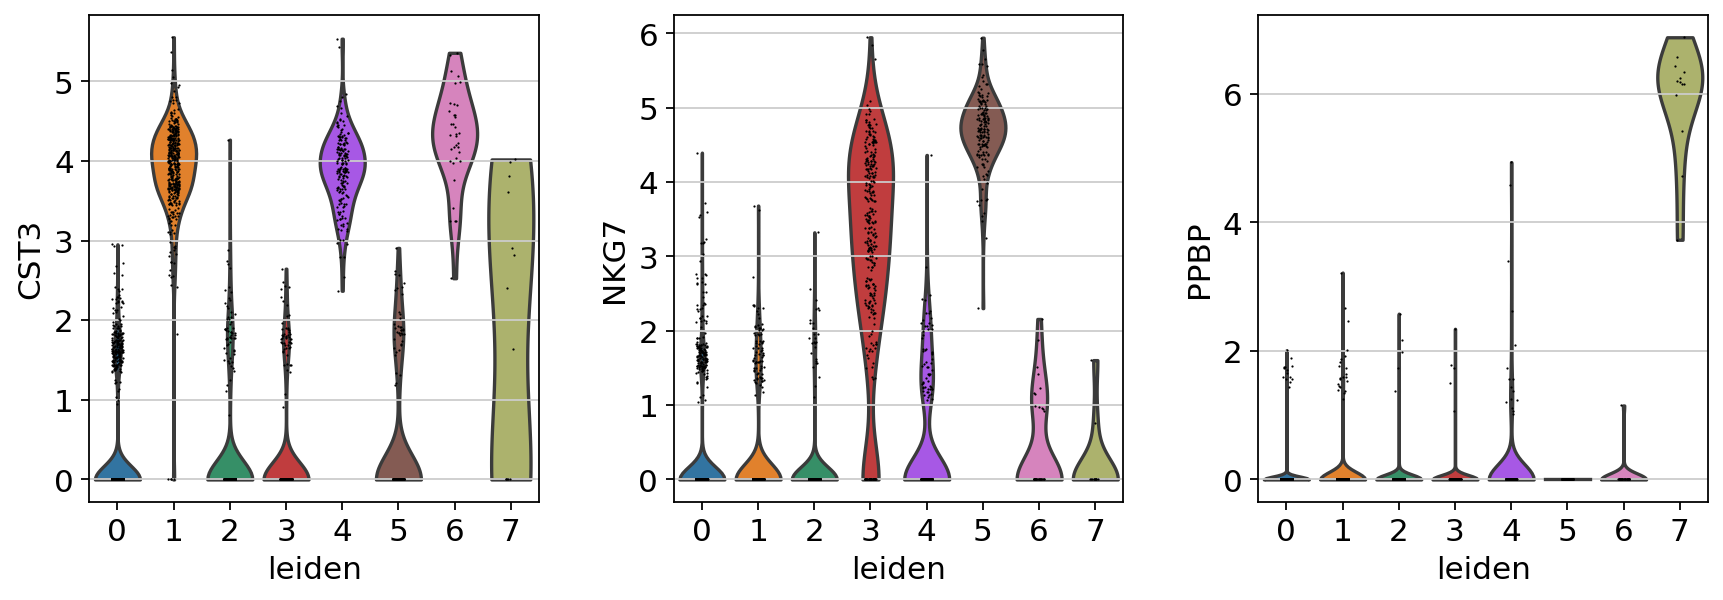

In [57]:
# to compare a certain gene across groups:
sc.pl.violin(adata, ['CST3', 'NKG7', 'PPBP'], groupby='leiden')

After obtaining a list of marker genes for each cluster, biological interpretation is performed to assign meaningful annotations to the clusters. This involves examining the known functions and expression patterns of the identified marker genes. Prior knowledge of cell type-specific or pathway-specific genes can aid in assigning cell type or functional annotations to the clusters.

Here, we can use canonical markers to easily match the unbiased clustering to known cell types:

In [58]:
# mark the cell types:
new_cluster_names = [
    'Naive CD4 T', 'CD14+ Mono',
    'B', 'CD8 T',
    'FCGR3A+ Mono', 'NK',
    'Dendritic', 'Platelet']
adata.rename_categories('leiden', new_cluster_names)

Omitting rank_genes_groups/names as old categories do not match.
Omitting rank_genes_groups/scores as old categories do not match.
Omitting rank_genes_groups/pvals as old categories do not match.
Omitting rank_genes_groups/pvals_adj as old categories do not match.
Omitting rank_genes_groups/logfoldchanges as old categories do not match.


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


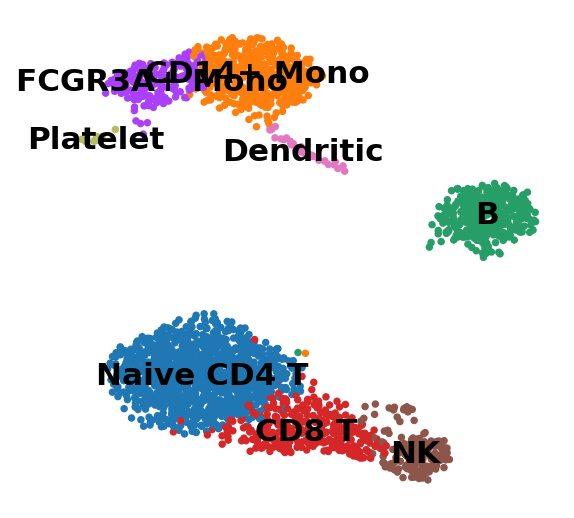

In [59]:
sc.pl.umap(adata, color='leiden', legend_loc='on data', title='', frameon=False, save='.pdf')

In [60]:
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'leiden', 'leiden_colors', 'leiden_sizes', 'log1p', 'neighbors', 'paga', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


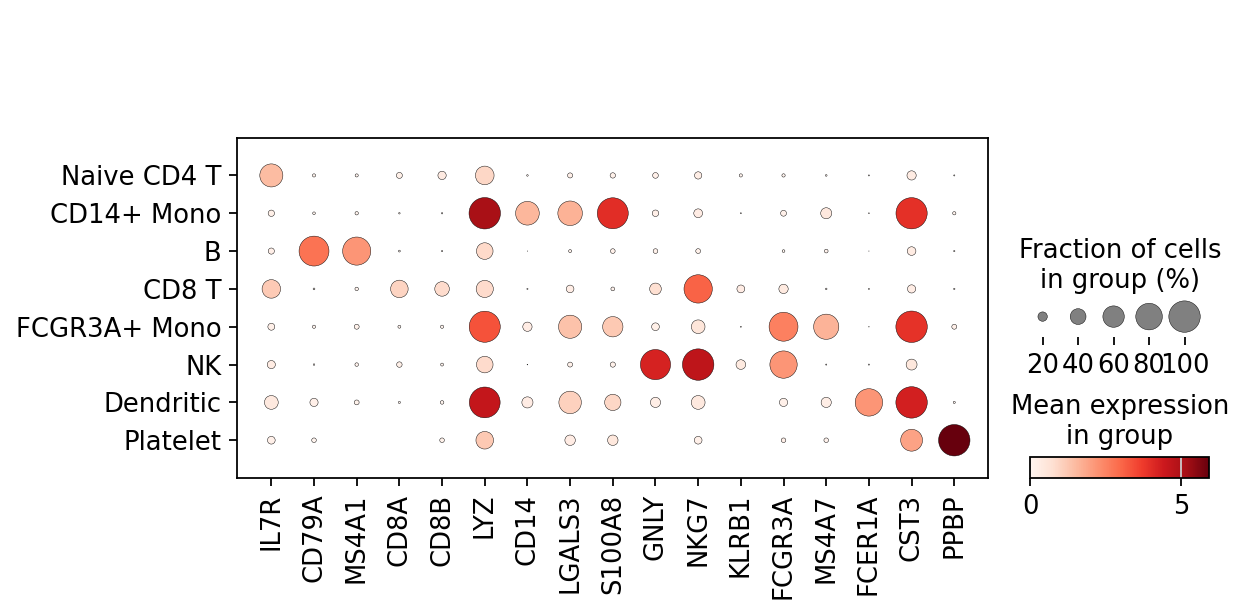

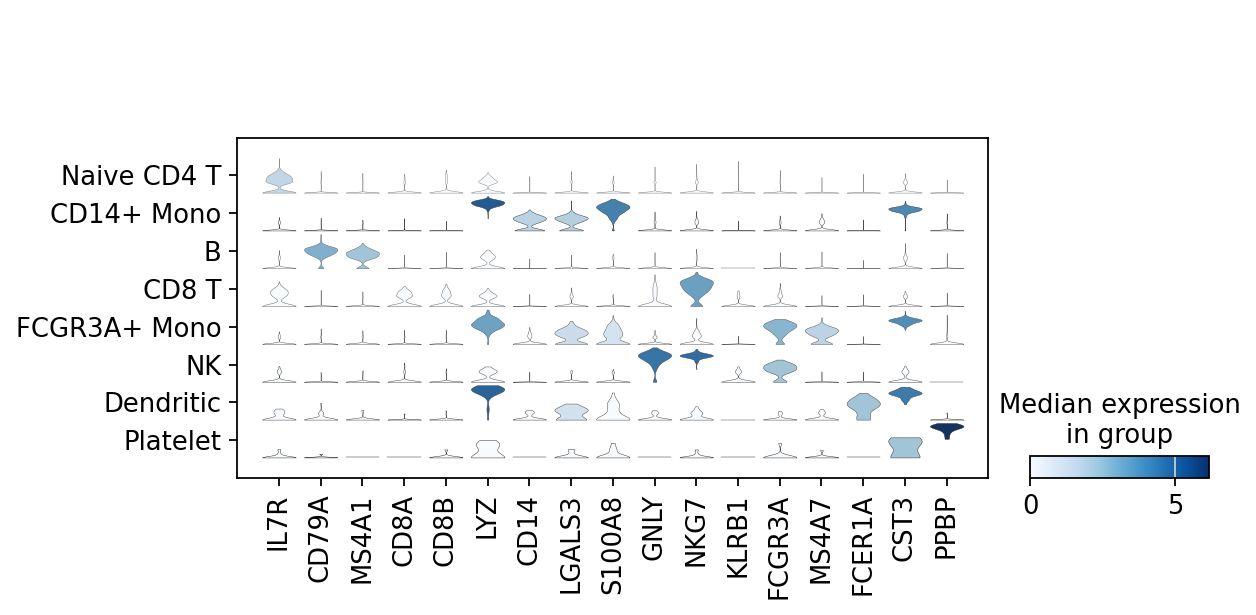

In [61]:
# we annotated the cell types, let us visualize the marker genes:
sc.pl.dotplot(adata, marker_genes, groupby='leiden');

# very compact violin plot:
sc.pl.stacked_violin(adata, marker_genes, groupby='leiden', rotation=90);

Trajectory

In [62]:
from pathlib import Path

import scanpy as sc

In [64]:
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'leiden', 'leiden_colors', 'leiden_sizes', 'log1p', 'neighbors', 'paga', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [65]:
sc.tl.diffmap(adata)
sc.pp.neighbors(adata, n_neighbors=10, use_rep='X_diffmap')

In [66]:
sc.tl.draw_graph(adata)


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


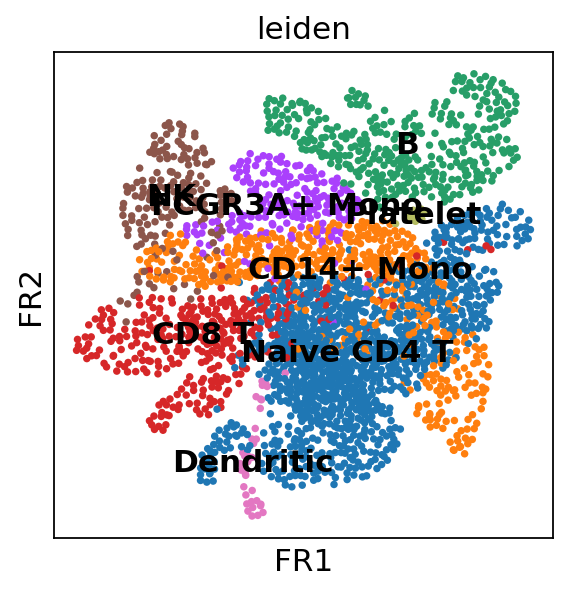

In [69]:
sc.pl.draw_graph(adata, color='leiden', legend_loc='on data')


In [73]:
!pip install louvain

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 47.3 MB/s eta 0:00:00


In [74]:
sc.tl.louvain(adata, resolution=1.0)


In [75]:
sc.tl.paga(adata, groups='louvain')


/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


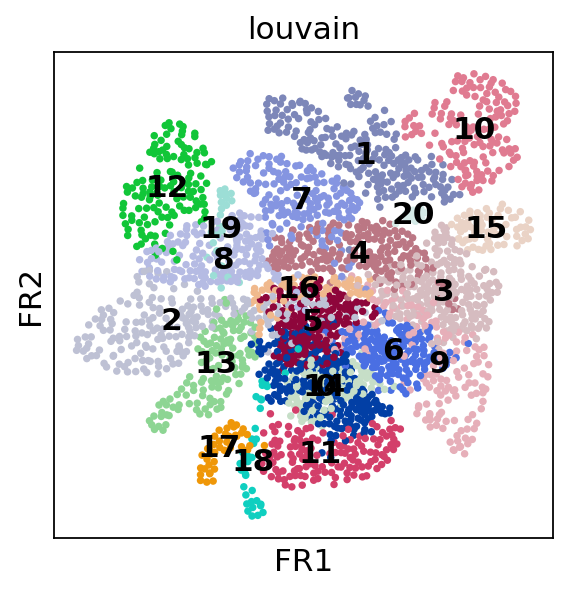

In [76]:
sc.pl.draw_graph(adata, color='louvain', legend_loc='on data')


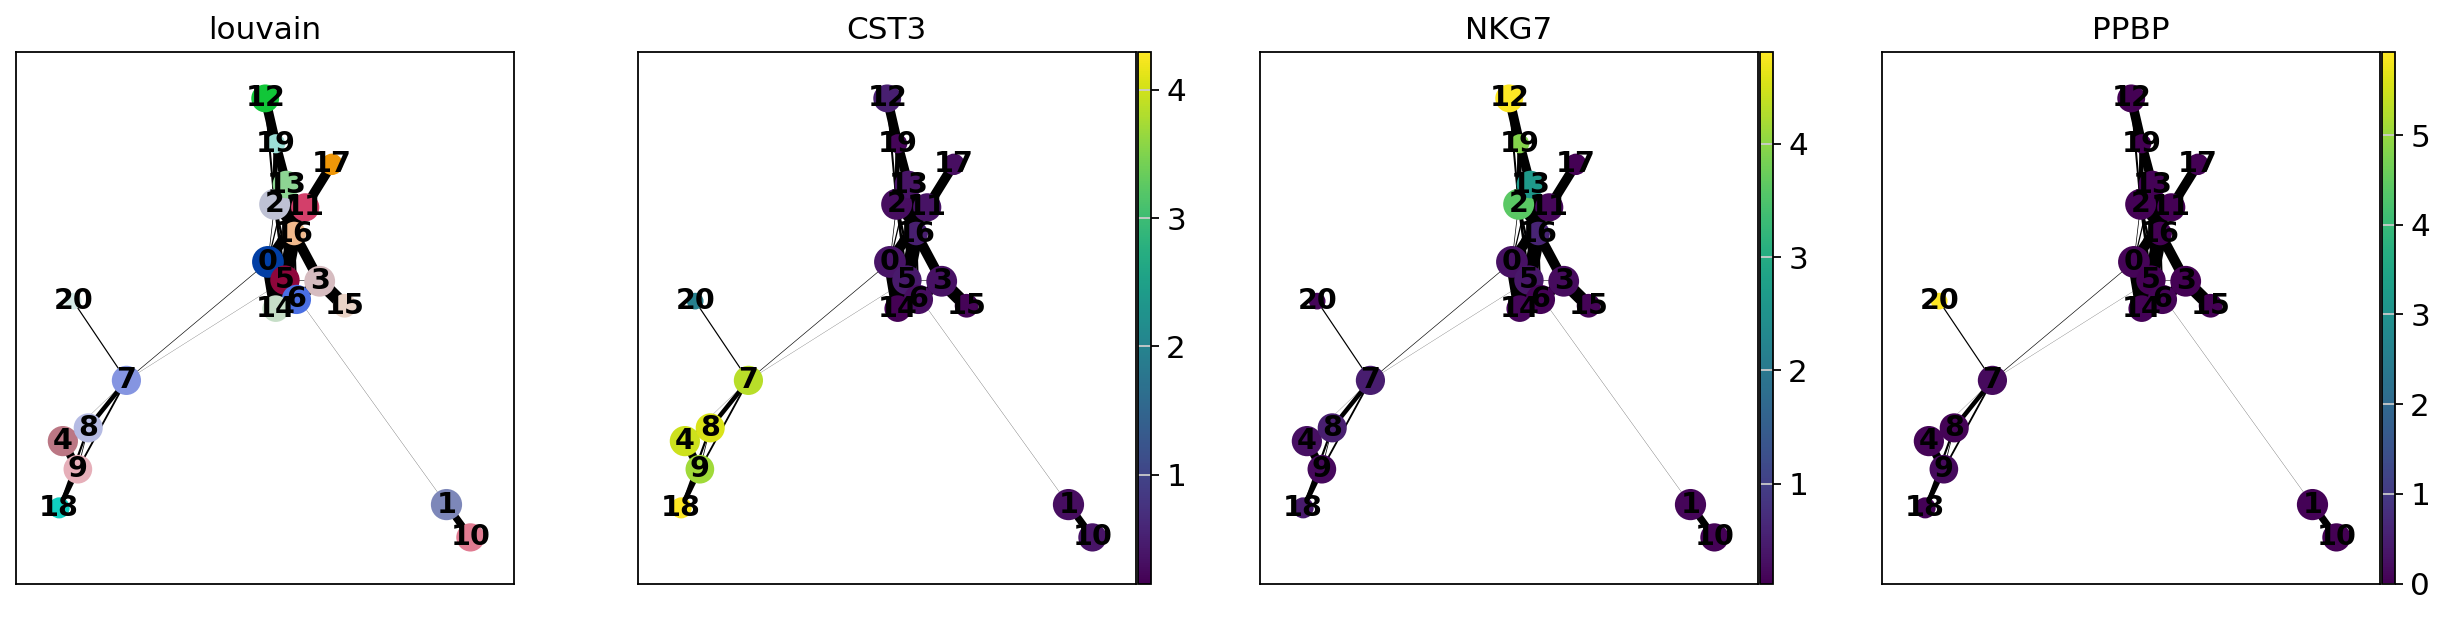

In [83]:
sc.pl.paga(adata, color=['louvain', 'CST3', 'NKG7', 'PPBP'])


In [84]:
adata.obs['louvain'].cat.categories


Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20'],
      dtype='object')

In [85]:
adata.obs['louvain_anno'] = adata.obs['louvain']


In [ ]:
import scanpy as sc
import monocle as monocle

# Assuming you have already loaded and preprocessed your single-cell data into a scanpy AnnData object 'adata'

# Perform dimensionality reduction if needed (e.g., PCA or t-SNE)
sc.pp.pca(adata)
sc.pp.neighbors(adata)

# Estimate pseudotime using Monocle
trajectory_data = monocle.data.MonocleData(adata.X, gene_names=adata.var_names)
trajectory_data = monocle.data.preprocessing.normalize_expression_data(trajectory_data)
trajectory_data = monocle.data.preprocessing.reduce_dimension(trajectory_data)
trajectory_data = monocle.data.preprocessing.cluster_data(trajectory_data)
trajectory_data = monocle.trajectory.pseudotime(trajectory_data)

# Access pseudotime values for cells
pseudotime_values = trajectory_data.pseudotime
